# Projet Leyenda - Livrable 1 - Classification binaire

## Sommaire

* [1. Introduction](#chapiter1)
    * [1.1. Rappel du besoin](#section_1_1)
    * [1.2. Expression du besoin](#section_1_2)
    * [1.3. Contraintes](#section_1_3)
* [2. Réalisation du modèle de classification](#chapter2)
    * [2.1. Import des librairies Python](#section_2_1) 
* [3. Analyse des résultats](#chapiter3)
* [4. Amélioration du modèle](#chapiter4)
* [5. Conclusion](#chapitre5)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet l'entreprise TouNum spécialisée dans la numérisation de documents souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possédant une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité l’entreprise décide d’innover et proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science de CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus aux quelles la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé nous pouvons nous aider du diagramme bête à corne ci dessous.</div>

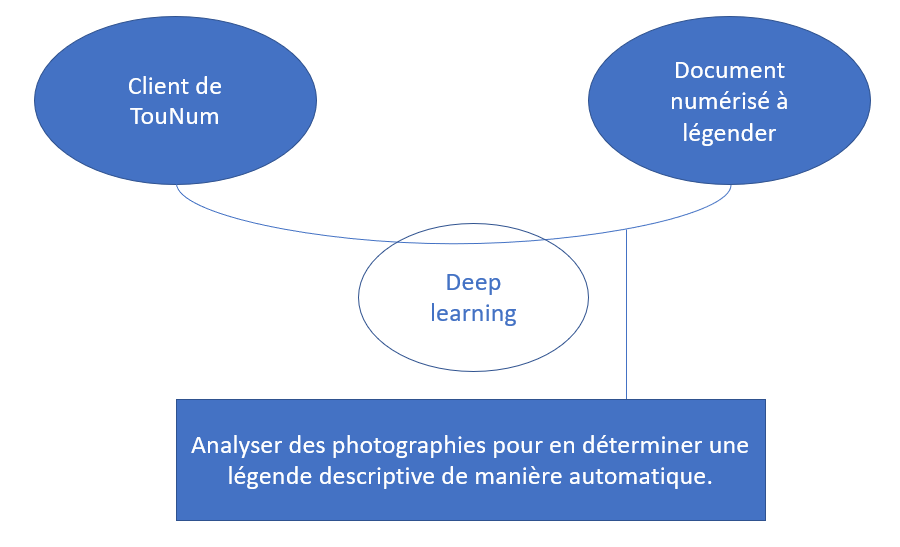
<center><em>Diagrame Bete à corne</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la  variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Réalisation du modèle de classification <a class="anchor" id="chapter2"></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [3]:
import pathlib

data_dir = pathlib.Path("Class")

In [4]:
image_h = 180
image_w = 180
batch_s = 32

In [5]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

Found 32080 files belonging to 5 classes.
Using 25664 files for training.
Found 32080 files belonging to 5 classes.
Using 6416 files for validation.


In [6]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


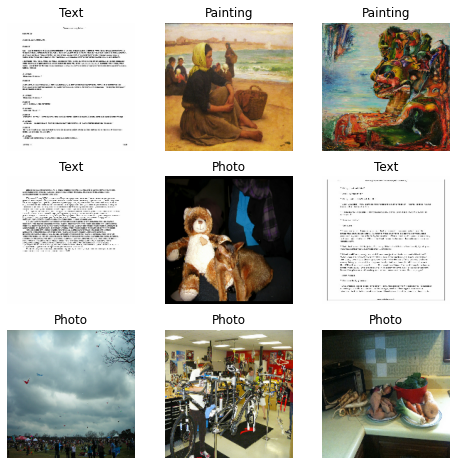

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

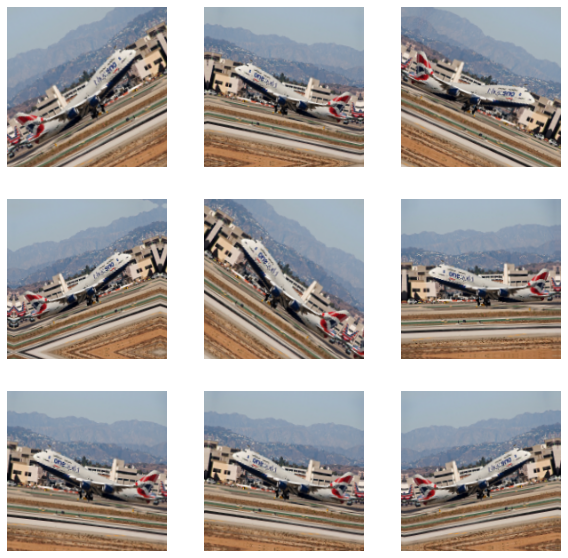

In [26]:
#Fonction s'occupant de la data augmentation, aujoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_h, 
                                                              image_w,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)       

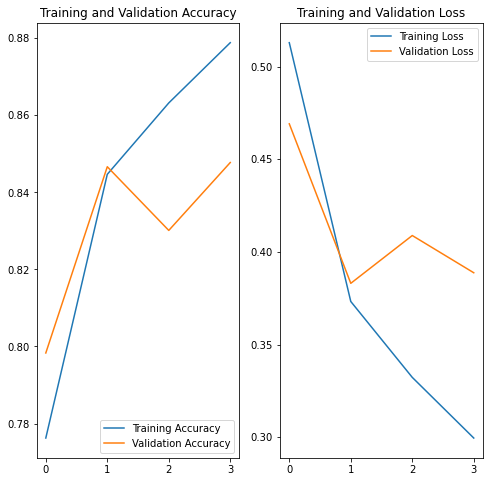

In [28]:

# Le modèle
complete_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])
# Compilation du modèle
complete_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()

# Enrainement du modèle
epochs = 4
history = complete_model.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous d'autre ?
<em>À COMPLÉTER</em>


In [32]:
#from keras.preprocessing import image

#img_path = 'Screenshot_1.jpg'

#img = image.load_img(img_path, target_size=(180, 180))
#img = image.img_to_array(img, dtype=np.uint8)
#img=np.array(img)/255.0

#plt.title("Loaded Image")
#plt.axis('off')
#plt.imshow(img.squeeze())

#p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
#print("Maximum Probability: ",np.max(p[0], axis=-1))
#predicted_class = labels[np.argmax(p[0], axis=-1)]
#print("Classified:",predicted_class);

#if predicted_class == 'Photo' :

 #print("Classified:",predicted_class);


#else :
    
      #print("N'est pas photo ");
